# Compare - Shanghai Composite Index

1. PAPER: [Financial Time Series Forecasting with the Deep Learning Ensemble Model](https://www.mdpi.com/2227-7390/11/4/1054) by He K., et al. 2023
2. NOTE (of stock data):
    1. **Raw Data** is mostly non-stationary.
    2. **Returns Data** is stationary and also called differenced.

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

from collections import namedtuple
from data_loader import build_stock_uts, build_downloaded_stock_uts
from time_series import TimeSeriesFactory
from data_plotter import InterpolatePlotter
from ts_models_no_retrain import augment_retrain_predictions, AR_Model, MA_Model, ARMA_Model, ARIMA_Model, EvaluationMetric

## Stock Data: Analysis

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data

## Stock Data: Models

11. Split Returns Data
12. Initialize Models: `AR(p)` and `ARMA(p, q)`
13. Split Raw Data
14. Initialize Model: `ARMA(p, d, q)`

## Stock Data: Evaluation Metrics + Plots

15. Evaluation Metrics `MSE`, `RMSE`
16. Plot Actual Predictions vs Model Predictions

## Follow-up

- Notes on above

## Stock Data: Analysis

### Load Raw Data

In [36]:
# Only grab stocks whose data is available for the entire time period
train_start_date, train_end_date = "2010-01-04", "2020-02-07"
test_start_date, test_end_date = "2020-02-07", "2024-06-08"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("000001.SS", "Shanghai Composite Index")
]
independent_variable = "Close"
frequency = '1d'
stocks = [Stock(*s) for s in stocks]
train_stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=train_start_date, end_date=train_end_date, frequency=frequency) for s in stocks}
test_stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=test_start_date, end_date=test_end_date, frequency=frequency) for s in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [37]:
values_cols = list(train_stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=train_stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in train_stocks.values()]
)

values_cols = list(test_stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=test_stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in test_stocks.values()]
)

Len [2447]
Len [2447]
Len [1053]
Len [1053]


In [38]:
stock_symbol = '000001.SS'
train_stock_of_interest = train_stocks[stock_symbol]
test_stock_of_interest = test_stocks[stock_symbol]
type(train_stock_of_interest), train_stock_of_interest, type(test_stock_of_interest), test_stock_of_interest

(time_series.UnivariateTimeSeries,
 UnivariateTimeSeries(Close),
 time_series.UnivariateTimeSeries,
 UnivariateTimeSeries(Close))

In [39]:
train_stock_df = train_stock_of_interest.get_as_df()
test_stock_df = test_stock_of_interest.get_as_df()
train_stock_df.tail(7)

,Close
Date,
2020-01-21,3052.139893
2020-01-22,3060.754883
2020-01-23,2976.528076
2020-02-03,2746.605957
2020-02-04,2783.288086
2020-02-05,2818.087891
2020-02-06,2866.510010


### Plot Raw Data

In [40]:
test_stock_df.head(7)

,Close
Date,
2020-02-07,2875.959961
2020-02-10,2890.488037
2020-02-11,2901.669922
2020-02-12,2926.898926
2020-02-13,2906.073975
2020-02-14,2917.008057
2020-02-17,2983.622070


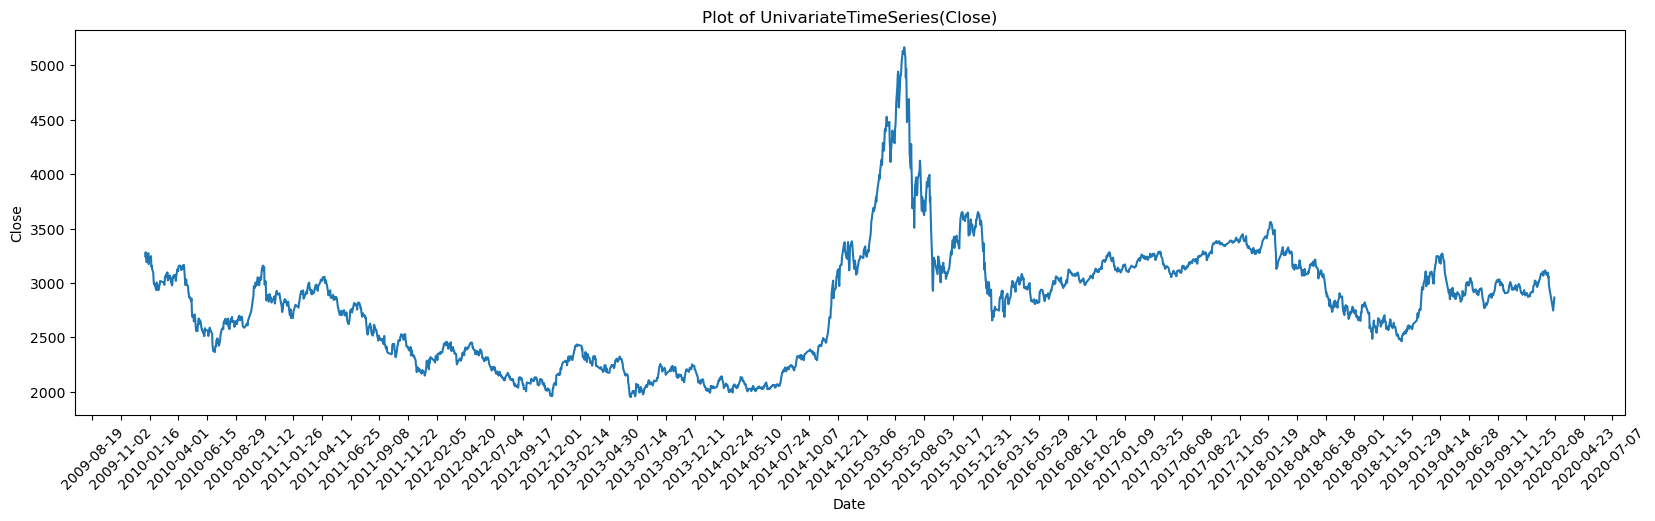

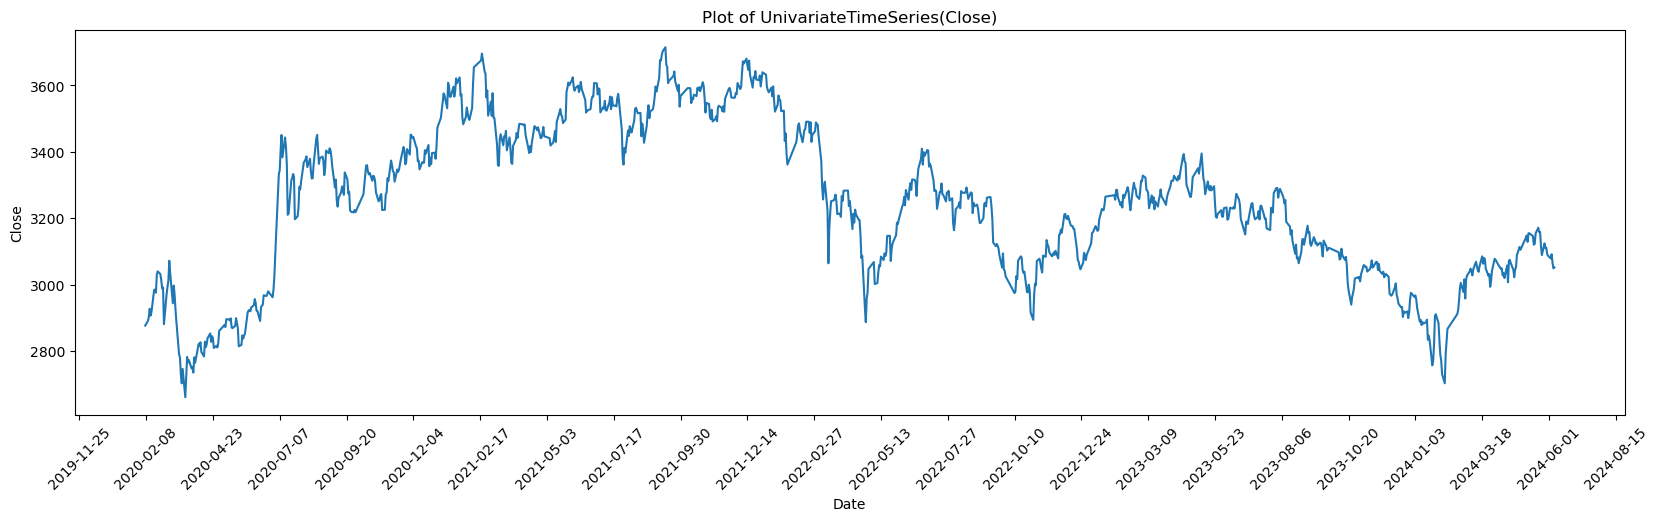

In [41]:
train_stock_of_interest.plot(tick_skip=75)
test_stock_of_interest.plot(tick_skip=75)

### Get Descriptive Statistics of Raw Data

In [8]:
time_type = 'days'
stock_data = True
train_stock_of_interest.get_statistics(time_type, stock_data)

,Close
total days,2447.0
most recent date,2015-06-12 00:00:00
inception date,2013-06-27 00:00:00
lowest price,1950.01
highest price,5166.35
average price,2801.36
range,3216.34
price volatility,529.3
25th percentile price,2346.35
median price,2859.76


### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary (as in there's a change in either or both the mean of the variance between two distant points).

In [9]:
train_stock_of_interest.stationarity_test(train_stock_df), test_stock_of_interest.stationarity_test(test_stock_df)

ADF Statistic: -2.226796
p-value: 0.196664 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -2.487650
p-value: 0.118508 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


(None, None)

### Plot Autocorrelation and Partial Autocorrelation of Raw Data

- Not required for `AR` or `ARMA` models as both models assumes stationary and the TS is non-stationary.
- Get the last X lags
    - X should be end of train and start of test
    - X also should be within the blue confidence region
    - if X = 200, it's NOT 200 of the end of train and start of test. X is 200 of the start train. Needs to be end of train.

In [10]:
# Use the last N days to predict the next N days, or reworded as 
# Predict the next N days (which is the full length of test set) and use the last N days to do so
train_stock_df[len(test_stock_df):]

,Close
Date,
2014-05-15,2024.973999
2014-05-16,2026.504028
2014-05-19,2005.182983
2014-05-20,2008.119019
2014-05-21,2024.951050
...,...
2020-01-23,2976.528076
2020-02-03,2746.605957
2020-02-04,2783.288086


In [11]:
# Since we don't have the compute power to process in a shorter time and we only care for the 
# significant lags (ie: those that are outside of the blue region), choose a max lag based on these two criteriors
# Thus, choose the last 200 days of train
last_N_train_df = train_stock_df.iloc[-500:, :]
last_N_train_df

,Close
Date,
2018-01-09,3413.899902
2018-01-10,3421.833984
2018-01-11,3425.344971
2018-01-12,3428.940918
2018-01-15,3410.488037
...,...
2020-01-23,2976.528076
2020-02-03,2746.605957
2020-02-04,2783.288086


In [12]:
test_stock_df

,Close
Date,
2020-02-07,2875.959961
2020-02-10,2890.488037
2020-02-11,2901.669922
2020-02-12,2926.898926
2020-02-13,2906.073975
...,...
2024-06-03,3078.489014
2024-06-04,3091.198975
2024-06-05,3065.403076


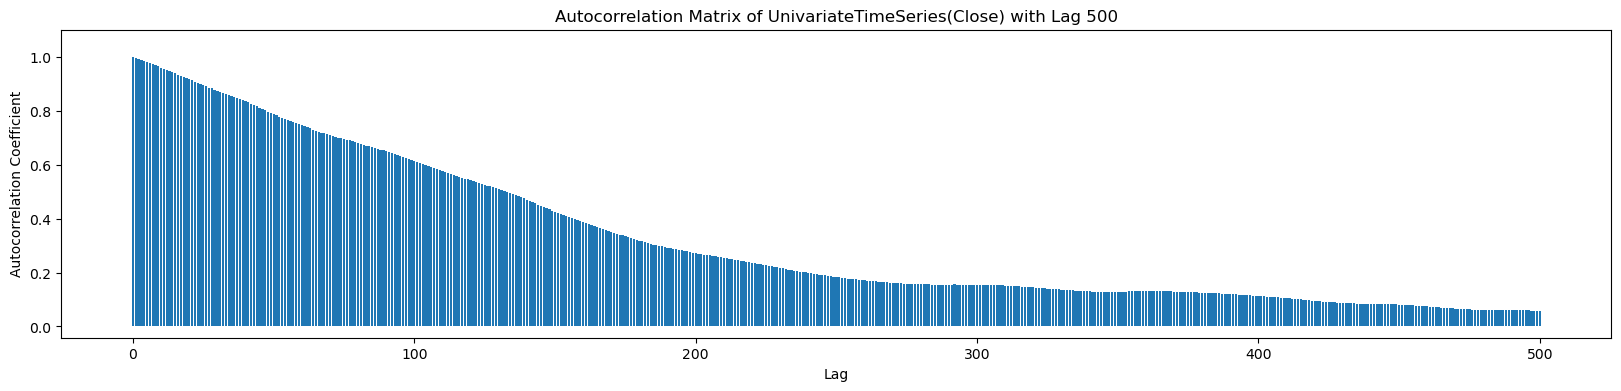

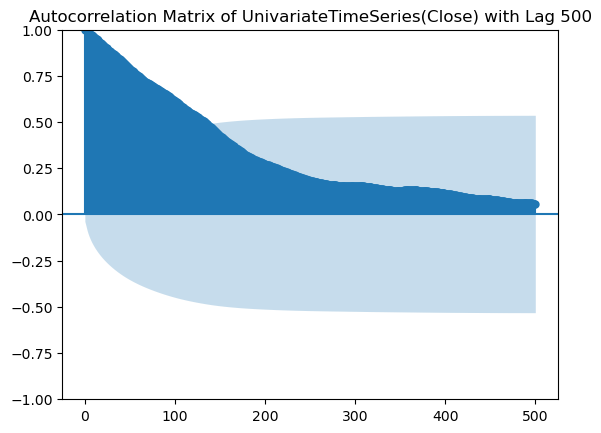

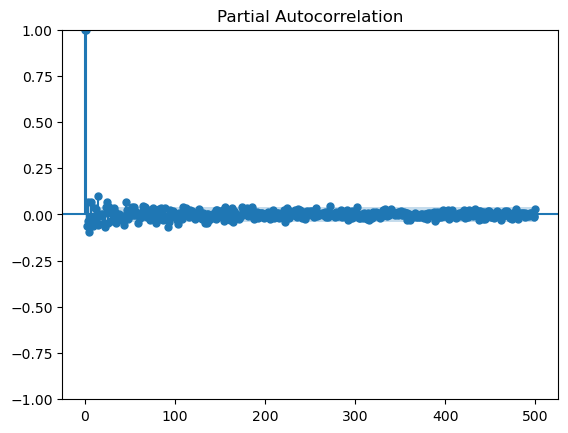

In [13]:
train_stock_of_interest.plot_autocorrelation(len(last_N_train_df))
train_stock_of_interest.plot_partial_autocorrelation(len(last_N_train_df))

- What is the above telling us?
    - Both plots are the same, just showing differently. 
    - Both plots confirm that the TS is non-stationary as in the current value depends on the previous value. We don't want this with traditional TS models like `AR`, `ARMA`.

- What is the above telling us?
    - TS is non-stationary. Although data isn't as dependent (like the ACorr plot), the 1st is dependent upon the 0th. 

### Get Returns Data

- This should provide us with stationary data that we can pass to both `AR` and `ARMA` models.

In [14]:
# len(stock_of_interest.get_series()), stock_of_interest.get_series()
# stock_returns = stock_of_interest.data_augment_for_returns()
# stock_returns.plot(tick_skip=150)
# stock_returns_df = stock_returns.get_as_df()
# stock_returns.get_statistics()
# stock_returns.stationarity_test(stock_returns_df)
# stock_returns.independence_test(stock_returns_df)
# stock_returns.plot_autocorrelation(50)
# stock_returns.plot_partial_autocorrelation(50)

- What is the above telling us?
    - TS is stationary. The 1st is not dependent upon the 0th. This is what we want for `AR(p)`.
    - Lag exponentially decays at 1, thus use lag 1 for `AR(p)` as they have in the PAPER.

## Stock Data: Models

### Split Differenced Data for `AR(p)`, `MA(q)`, `ARMA(p, q)` Models

- Make 5-day forecasts

In [15]:
# stock_returns.get_as_df()

In [16]:
# interpolation_step = 5
# interpolation_step = 120
# N_train = len(train_stock_of_interest.get_series()[lags:])
# interpolation_step = len(test_stock_of_interest.get_series())
# diff_train_length = N_train - interpolation_step

# print(f"Train {diff_train_length}")


In [17]:
# interpolation_step = 1956
# # interpolation_step = 60
# N = len(stock_returns.get_series())
# diff_train_length = N - interpolation_step
# diff_train_length

In [18]:
# diff_train_uts, diff_test_uts = train_stock_of_interest.get_slice(1, len(N_train), both_train_test=True)
# diff_train_uts, diff_test_uts

In [19]:
# diff_train_df = diff_train_uts.get_as_df()
# diff_train_df
# diff_train_values = diff_train_uts.get_series()
# diff_train_values
# diff_test_df = diff_test_uts.get_as_df()
# diff_test_df
# diff_test_values = diff_test_uts.get_series()
# len(diff_test_values)

In [20]:
N_test_df = len(test_stock_df)
N_test_df

1053

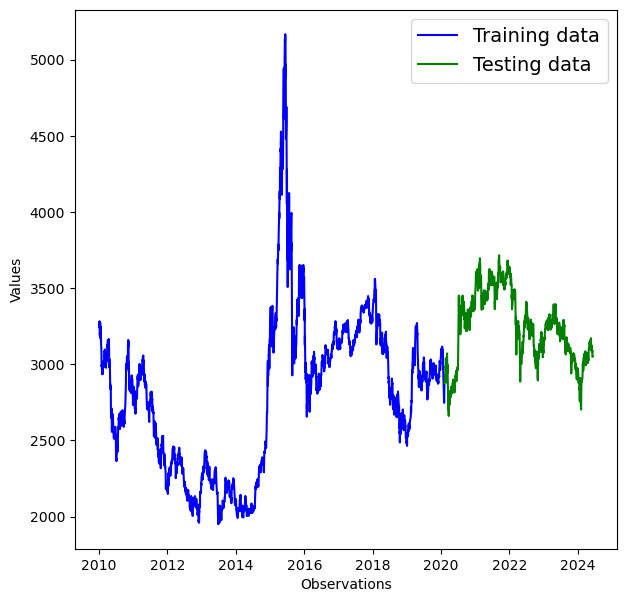

In [21]:
scatter_type = False
data_prediction_plots = InterpolatePlotter()
data_prediction_plots.plot_ts_training_and_testing_data(train_stock_df, test_stock_df, scatter_type)

#### Initialize Model: `AR(p)`

- Pass `diff_test_values` series instead of `diff_train_df` to drop index of the returned prediction
- Train data: Entire train dataset
- Lags: Of the X last days in train dataset (as in the last day in train + 1 (if not a weekend) and it should be the next day in test), where does significance fall out of range?

In [22]:
lag_p = 1

In [23]:
train_stock_values = train_stock_df.values
train_values = augment_retrain_predictions(train_stock_values)
len(train_values), train_values

(2447,
 array([3243.76000977, 3282.17895508, 3254.21508789, ..., 2783.28808594,
        2818.08789062, 2866.51000977]))

In [24]:
len(last_N_train_df)


500

In [25]:
no_retrain_name = ' - no retrain'
no_retrain_bool = False

ar_no_retrain_model_class = AR_Model(no_retrain_name, lag_p=len(last_N_train_df))
ar_no_retrain_model_class.train(train_values)
ar_no_retrain_model_class.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                 2447
Model:                   AutoReg(500)   Log Likelihood               -9849.044
Method:               Conditional MLE   S.D. of innovations             38.078
Date:                Sun, 04 Aug 2024   AIC                          20702.087
Time:                        14:39:55   BIC                          23500.258
Sample:                           500   HQIC                         21730.914
                                 2447                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2079      6.500      1.570      0.116      -2.532      22.948
y.L1           1.0691      0.023     47.195      0.000       1.025       1.114
y.L2          -0.1116      0.033     -3.368      0.001      -0.177      -0.047
y.L3           0.0896      0.033      2.697      0.007       0.024       0.155
y.L4           0.0463      0.033      1.385      0.166      -0.019       0.112
y.L5          -0.1009      0.033     -3.018      0.003      -0.166      -0.035
y.L6          -0.0648      0.034     -1.935      0.053      -0.131       0.001
y.L7           0.1413      0.034      4.215      0.000       0.076       0.207
y.L8          -0.0437      0.034     -1.298      0.194      -0.110       0.022
y.L9          -0.0065      0.034     -0.192      0.848      -0.073       0.060
y.L10         -0.0668      0.034     -1.983      0.047      -0.133      -0.001
y.L11          0.0369      0.034      1.093      0.275      -0.029       0.103
y.L12         -0.0017      0.034     -0.049      0.961      -0.068       0.064
y.L13          0.0656      0.034      1.943      0.052      -0.001       0.132
y.L14         -0.1758      0.034     -5.206      0.000      -0.242      -0.110
y.L15          0.1918      0.034      5.640      0.000       0.125       0.258
y.L16         -0.0488      0.034     -1.424      0.155      -0.116       0.018
y.L17         -0.0219      0.034     -0.638      0.524      -0.089       0.045
y.L18         -0.0085      0.034     -0.249      0.804      -0.076       0.059
y.L19         -0.0064      0.034     -0.187      0.851      -0.074       0.061
y.L20          0.0697      0.034      2.029      0.042       0.002       0.137
y.L21          0.0342      0.034      0.995      0.320      -0.033       0.102
y.L22         -0.1296      0.034     -3.767      0.000      -0.197      -0.062
y.L23         -0.0216      0.035     -0.626      0.531      -0.089       0.046
y.L24          0.0453      0.035      1.311      0.190      -0.022       0.113
y.L25          0.0804      0.035      2.327      0.020       0.013       0.148
y.L26         -0.0904      0.035     -2.615      0.009      -0.158      -0.023
y.L27          0.0163      0.035      0.470      0.638      -0.052       0.084
y.L28          0.0206      0.035      0.596      0.551      -0.047       0.088
y.L29         -0.0187      0.035     -0.540      0.589      -0.087       0.049
y.L30         -0.0214      0.035     -0.618      0.537      -0.089       0.046
y.L31         -0.0228      0.035     -0.659      0.510      -0.091       0.045
y.L32          0.0329      0.035      0.951      0.342      -0.035       0.101
y.L33          0.0772      0.035      2.233      0.026       0.009       0.145
y.L34         -0.0012      0.035     -0.034      0.973      -0.069       0.067
y.L35         -0.0366      0.035     -1.058      0.290      -0.104       0.031
y.L36          0.0062      0.035      0.179      0.858      -0.062       0.074
y.L37         -0.0620      0.035     -1.792      0.073      -0.130       0.006
y.

In [26]:
test_stock_values = test_stock_df.values
test_values = augment_retrain_predictions(test_stock_values)
len(test_values), test_values

(1053,
 array([2875.95996094, 2890.48803711, 2901.66992188, ..., 3065.40307617,
        3048.79394531, 3051.27905273]))

In [27]:
# retrain false
ar_predictions = ar_no_retrain_model_class.make_predictions(train_values, test_values)
ar_predictions
all_predictions_df = ar_no_retrain_model_class.model_predictions_to_df(test_stock_df, ar_predictions)
all_predictions_df

,Close,AR Model - no retrain
Date,,
2020-02-07,2875.959961,2883.218451
2020-02-10,2890.488037,2868.451570
2020-02-11,2901.669922,2889.558772
2020-02-12,2926.898926,2881.751701
2020-02-13,2906.073975,2860.241428
...,...,...
2024-06-03,3078.489014,2863.205306
2024-06-04,3091.198975,2860.586382
2024-06-05,3065.403076,2855.655492


In [28]:
ar_model_pred_name = f"{ar_no_retrain_model_class.__name__()}{no_retrain_name}"
ar_predictions_df = all_predictions_df.loc[:, ar_model_pred_name]
ar_predictions_df

Date
2020-02-07    2883.218451
2020-02-10    2868.451570
2020-02-11    2889.558772
2020-02-12    2881.751701
2020-02-13    2860.241428
                 ...     
2024-06-03    2863.205306
2024-06-04    2860.586382
2024-06-05    2855.655492
2024-06-06    2856.488812
2024-06-07    2860.038636
Name: AR Model - no retrain, Length: 1053, dtype: float64

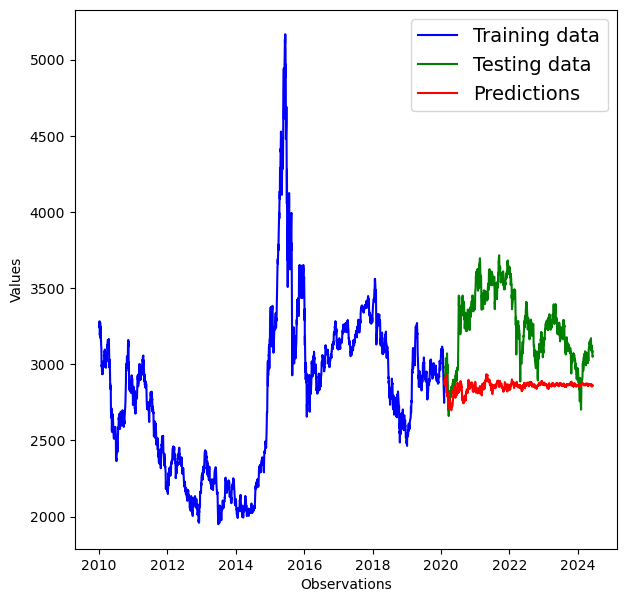

In [29]:
data_prediction_plots.plot_ts_training_and_testing_data(train_stock_df, test_stock_df, scatter_type, ar_predictions_df)

In [30]:
EvaluationMetric.eval_mse(test_stock_df, ar_predictions_df, per_element=False)
EvaluationMetric.eval_rmse(test_stock_df, ar_predictions_df, per_element=False)

Test MSE: 205498.258
Test RMSE: 453.319


#### Initialize Model: `MA(q)`

In [ ]:
no_retrain_name

In [ ]:
error_q = 1 # MA
ma_model_class = MA_Model(no_retrain_name, error_q=error_q)
ma_model_class.train(diff_train_df.values)
ma_model_class.summary()

In [ ]:
ma_predictions_no_retrain = ma_model_class.make_predictions(diff_train_df, diff_test_df)
all_predictions_df = ma_model_class.model_predictions_to_df(diff_test_df, ma_predictions_no_retrain)
all_predictions_df

In [ ]:
ma_predictions_df = all_predictions_df.iloc[:, 2]
ma_predictions_df

In [ ]:
EvaluationMetric.eval_mse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 2], per_element=False)
EvaluationMetric.eval_rmse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 2], per_element=False)

data_prediction_plots.plot_ts_training_and_testing_data(diff_train_df, diff_test_df, scatter_type, ma_predictions_df)

#### Initialize Model: `ARMA(p, q)`

In [ ]:
arma_model_class = ARMA_Model(no_retrain_name, lag_p, error_q)
arma_model_class.train(diff_train_df.values)
arma_model_class.summary()

NOTE: Should Dep. Variable be t as t depends on t - 1?

In [ ]:
# retrain false
arma_predictions_no_retrain = arma_model_class.make_predictions(diff_train_df, diff_test_df)
all_predictions_df = arma_model_class.model_predictions_to_df(diff_test_df, arma_predictions_no_retrain)
all_predictions_df

In [ ]:
arma_predictions_df = all_predictions_df.iloc[:, 3]
arma_predictions_df

In [ ]:
EvaluationMetric.eval_mse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 3], per_element=False)
EvaluationMetric.eval_rmse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 3], per_element=False)

data_prediction_plots.plot_ts_training_and_testing_data(diff_train_df, diff_test_df, scatter_type, arma_predictions_df)

### Split Raw Data for `ARIMA(p, d, q)` Model

- Make 5-day forecasts

In [ ]:
# interpolation_step = 5
# interpolation_step = 60
# N = len(stock_of_interest.get_series())
# train_length = N - interpolation_step
# train_length

N = len(stock_of_interest.get_series())
interpolation_step = N - int(N * .8)
train_length = N - interpolation_step

print(f"IS: {interpolation_step}\nTrain {diff_train_length}")

In [ ]:
train_uts, test_uts = stock_of_interest.get_slice(start=1, end=train_length, both_train_test=True)
train_uts, test_uts

In [ ]:
train_df = train_uts.get_as_df()
test_df = test_uts.get_as_df()
train_df.plot(), test_df.plot()

In [ ]:
train_values = train_uts.get_series()
test_values = test_uts.get_series()
len(train_values), len(test_values)

In [ ]:
arima_plotter = InterpolatePlotter()
arima_plotter.plot_ts_training_and_testing_data(train_df, test_df, True)
arima_plotter.plot_ts_training_and_testing_data(train_df, test_df, False)

#### Initialize Models: `ARIMA(p, d, q)`

In [ ]:
diff_d = 1

arima_model_class = ARIMA_Model(no_retrain_name, lag_p, error_q, diff_d)
trained_arima_model = arima_model_class.train(train_values)
# trained_arima_model.summary()

In [ ]:
arima_predictions = arima_model_class.make_predictions(diff_train_values, diff_test_values)
all_raw_predictions_df = arima_model_class.model_predictions_to_df(test_df, arima_predictions)
all_raw_predictions_df

In [ ]:
arima_predictions_df = all_raw_predictions_df.iloc[:, 1]
len(arima_predictions_df), arima_predictions_df.head(3)

In [ ]:
EvaluationMetric.eval_mse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 1], per_element=False)
EvaluationMetric.eval_rmse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 1], per_element=False)

arima_plotter.plot_ts_training_and_testing_data(train_df, test_df, scatter_type=False, predictions_df=arima_predictions_df)

## Stock Data: Evaluation Metrics + Plots

### Evaluation Metrics: MSE, RMSE

### Plots Actual Predictions vs Model Predictions
- Need to finish plots

## Follow-up